# Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

Running on device: CUDA


# Data

In [2]:
input_size = 7
# Step 1: Create a random numpy array X
X = np.random.uniform(0, 2, size=(8192, input_size)).astype(np.float32)

# Step 2: Calculate Y
Y = np.concatenate([1e3*np.sin(np.sum(X[:4096,:3], axis=1, keepdims=False)*1e-3), 1e3*np.sin(np.sum(X[4096:,-3:], axis=1, keepdims=False)*1e-3+np.pi)], axis=0)


In [3]:
Generator_Index = np.zeros_like(X[:,:1])
Generator_Index[:4096,:] = 1
Generator_Index[4096:,:] = 2
columns = ["Generator_Index"]
columns.extend([f"X{i}" for i in range(1,8)])
columns.extend(["Output"])
complete_data = pd.DataFrame(np.concatenate([Generator_Index, X, Y.reshape(-1,1)], axis=-1), columns=columns)
complete_data["Generator_Index"] = complete_data["Generator_Index"].astype(int)
complete_data.to_csv("complete_data.csv")
complete_data

,Generator_Index,X1,X2,X3,X4,X5,X6,X7,Output
0,1,0.983340,0.094450,0.297536,1.220669,0.348284,1.205728,0.708403,1.375325
1,1,0.720662,0.319987,0.440356,1.643303,1.194592,0.750792,1.689157,1.481005
2,1,1.866318,1.826279,1.916582,1.856237,0.924298,1.366719,1.230301,5.609149
3,1,0.991016,1.464941,0.801370,0.662116,1.081507,1.252021,1.937253,3.257321
4,1,1.882761,1.845147,0.719877,1.527299,1.578622,1.361010,0.095537,4.447771
...,...,...,...,...,...,...,...,...,...
8187,2,0.571911,1.449771,0.233479,0.301539,1.453656,0.460152,1.595325,-3.509125
8188,2,0.424644,0.762384,0.180900,0.873574,1.582734,0.303613,1.203341,-3.089749
8189,2,0.856483,0.742705,1.199195,1.967587,0.775728,1.028316,1.709969,-3.514132
8190,2,1.601231,0.258544,0.958398,0.131642,1.012445,0.984389,1.130132,-3.126942


Generator I's inputs

In [4]:
GI_inputs = pd.DataFrame(X[:4096,:],columns=columns[1:8])
(GI_inputs.iloc[:5]).to_csv("GI_inputs.csv")
GI_inputs.head()

,X1,X2,X3,X4,X5,X6,X7
0,0.983340,0.094450,0.297536,1.220669,0.348284,1.205728,0.708403
1,0.720662,0.319987,0.440356,1.643303,1.194592,0.750792,1.689157
2,1.866318,1.826279,1.916582,1.856237,0.924298,1.366719,1.230301
3,0.991016,1.464941,0.801370,0.662116,1.081507,1.252021,1.937253
4,1.882761,1.845147,0.719877,1.527299,1.578622,1.361010,0.095537


In [5]:
GII_inputs = pd.DataFrame(X[4096:,:],columns=columns[1:8])
(GII_inputs.iloc[:5]).to_csv("GII_inputs.csv")
GII_inputs.head()

,X1,X2,X3,X4,X5,X6,X7
0,1.344882,0.043036,1.376872,1.301069,0.166781,0.491644,0.050620
1,0.416870,1.499035,1.824690,1.991952,0.685698,0.290170,1.981935
2,1.043917,0.877336,0.790652,0.041428,0.229863,1.612218,0.265378
3,0.986892,0.967978,0.663806,1.362339,0.760583,0.523359,1.268226
4,1.228081,1.743830,0.307979,1.897783,1.266033,1.239091,1.706465


Visible data

In [6]:
data = (complete_data.iloc[1024:-1024])[columns[1:]]
data.to_csv("complete_data.csv")
data

,X1,X2,X3,X4,X5,X6,X7,Output
1024,0.229049,1.870184,1.100939,1.661020,1.624357,1.173618,0.318642,3.200166
1025,1.096563,1.537970,1.229099,0.989778,0.772538,1.154711,1.228566,3.863622
1026,0.151529,0.964341,1.968290,1.258648,1.989890,0.582316,0.936431,3.084155
1027,1.179227,0.095054,1.670490,0.859637,0.649466,0.766345,1.899151,2.944768
1028,0.758478,0.697240,1.705398,0.692344,1.540746,1.232414,0.070643,3.161110
...,...,...,...,...,...,...,...,...
7163,0.112258,0.745659,1.802214,1.477937,0.420151,1.253287,0.354776,-2.028313
7164,1.441342,0.910593,0.453119,0.346935,1.324813,1.543141,1.749911,-4.618000
7165,1.457872,1.682057,1.712196,0.477778,0.302874,1.431053,0.035256,-1.769152
7166,1.192866,0.953945,0.503439,1.960875,0.812511,1.653646,1.355900,-3.822166


# Explainable Data

In [7]:
class CustomDataset(Dataset):
    def __init__(self, dat):
        self.X = torch.tensor((dat.iloc[:,:-1]).values)
        self.Y = torch.tensor((dat.iloc[:,-1]).values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], idx
    
train_dataset = CustomDataset(data)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last=True)
viz_data = (complete_data.iloc[np.concatenate([np.arange(8192)[:1024],np.arange(8192)[-1024:]], axis=0)])[columns[1:]]
viz_set = CustomDataset(viz_data)
mixed_dataloader = DataLoader(viz_set, batch_size=512, shuffle=True)

In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.bn10 = nn.BatchNorm1d(2*input_size+1)
        self.fc10 = nn.Linear(2*input_size+1, 512)
        self.bn20 = nn.BatchNorm1d(512)
        self.fc20 = nn.Linear(512, 512)
        self.bn30 = nn.BatchNorm1d(512)
        self.fc30 = nn.Linear(512, 512)
        self.bn40 = nn.BatchNorm1d(512)
        self.fc40 = nn.Linear(512, 1)

    def forward(self, x):
        out0 = torch.tanh(self.fc10(self.bn10(x)))
        out0 = torch.tanh(self.fc20(self.bn20(out0)))
        out0 = torch.tanh(self.fc30(self.bn30(out0)))
        out0 = (self.fc40(self.bn40(out0))).reshape(-1)

        return out0

net = Model()
net.to(DEVICE)

Model(
  (bn10): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc10): Linear(in_features=15, out_features=512, bias=True)
  (bn20): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc20): Linear(in_features=512, out_features=512, bias=True)
  (bn30): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc30): Linear(in_features=512, out_features=512, bias=True)
  (bn40): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc40): Linear(in_features=512, out_features=1, bias=True)
)

In [9]:
epochs = 128

criterion = nn.MSELoss(reduction='none')
test_net = Model()
test_net.to(DEVICE)
net.train()
test_net.eval()
test_net.load_state_dict(net.state_dict())
optimizer = optim.Adam(net.parameters(), lr=0.01)

cohesive_scores = torch.from_numpy(np.zeros((len(train_dataloader.dataset),len(mixed_dataloader.dataset),1))).long()
cluster_scores = torch.from_numpy(np.zeros((len(mixed_dataloader.dataset),len(mixed_dataloader.dataset),1))).long()

for ep in range(1,epochs+1):
    ep_loss = 0.
    for i, (inputs, targets, tr_indices) in enumerate(train_dataloader):
        inputs, targets = inputs.float().to(DEVICE), targets.float().to(DEVICE)
        t_values = torch.topk((cohesive_scores[tr_indices,:,0]),1,dim=1)
        t_indices = t_values.indices[:,-1]
        t_inputs = torch.from_numpy(viz_data.iloc[t_indices.numpy(),:-1].values).to(DEVICE)
        t_targets = torch.from_numpy(viz_data.iloc[t_indices.numpy(),-1].values).to(DEVICE)
        cohesive_scores_tmpt = 0.-(cohesive_scores[:,:,0])
        null_indices = np.random.permutation(len(mixed_dataloader.dataset))[:int(.2*len(mixed_dataloader.dataset))]
        cohesive_scores_tmpt[:,null_indices] = cohesive_scores_tmpt.min()-1
        c_values = torch.topk((cohesive_scores_tmpt[tr_indices,:]),1,dim=1)
        c_indices = c_values.indices[:,-1]
        c_inputs = torch.from_numpy(viz_data.iloc[c_indices.numpy(),:-1].values).to(DEVICE)
        c_targets = torch.from_numpy(viz_data.iloc[c_indices.numpy(),-1].values).to(DEVICE)

        inputs_0 = torch.cat([inputs, c_inputs, c_targets.reshape(-1,1)],dim=-1)

        test_net.load_state_dict(net.state_dict())
        optimizer.zero_grad()
        output_0 = net(inputs_0)
        loss = criterion(output_0, targets).mean()
        loss.backward()
        optimizer.step()

        ep_loss = ep_loss+criterion(output_0, targets).mean().item()

        net.eval()
        test_net.eval()
        with torch.no_grad():
            output00 = net(inputs_0)
            loss_0 = criterion(output00, targets)
            output10 = test_net(inputs_0)
            loss_1 = criterion(output10, targets)
            tr_sign_batch_val = torch.sign(loss_0-loss_1).long().reshape(-1,1)

            for _, (inputs, targets, mi_indices) in enumerate(mixed_dataloader):
                cluster_indices = np.array(mi_indices)
                inputs = inputs.to(DEVICE)
                targets = targets.to(DEVICE)
                c_values = torch.topk(-(cohesive_scores[:,mi_indices,0]).T,1,dim=1)
                c_indices = c_values.indices[:,-1]
                c_inputs = torch.from_numpy(data.iloc[c_indices.numpy(),:-1].values).to(DEVICE)
                c_targets = torch.from_numpy(data.iloc[c_indices.numpy(),-1].values).to(DEVICE)

                inputs_1 = torch.cat([inputs, c_inputs, c_targets.reshape(-1,1)],dim=-1)

                output01 = net(inputs_1)
                loss_0 = criterion(output01, targets)
                output11 = test_net(inputs_1)
                loss_1 = criterion(output11, targets)
                mi_sign_batch_val = torch.sign(loss_0-loss_1).long().reshape(-1,1)

                ones = torch.ones(len(tr_sign_batch_val),len(mi_sign_batch_val),1).long().to(DEVICE)
                sq = torch.mul(ones,mi_sign_batch_val.long().view(1,-1,1))
                sq = torch.mul(sq,tr_sign_batch_val.long().view(-1,1,1))
                tr_indices_sq = tr_indices.view(-1,1).expand(len(tr_sign_batch_val),len(mi_sign_batch_val))
                mi_indices_sq = mi_indices.view(1,-1).expand(len(tr_sign_batch_val),len(mi_sign_batch_val))
                sq = sq.cpu().reshape(-1,1)
                tr_indices_sq = tr_indices_sq.cpu().reshape(-1)
                mi_indices_sq = mi_indices_sq.cpu().reshape(-1)

                cohesive_scores[tr_indices_sq,mi_indices_sq,:1] = cohesive_scores[tr_indices_sq,mi_indices_sq,:1]+sq[:,:1]

                ######################################################################################

                ones = torch.ones(len(mi_sign_batch_val),len(mi_sign_batch_val),1).long().to(DEVICE)
                sq = torch.mul(ones,mi_sign_batch_val.long().view(1,-1,1))
                sq = torch.mul(sq,mi_sign_batch_val.long().view(-1,1,1))
                f_indices_sq = mi_indices.view(-1,1).expand(len(mi_sign_batch_val),len(mi_sign_batch_val))
                n_indices_sq = mi_indices.view(1,-1).expand(len(mi_sign_batch_val),len(mi_sign_batch_val))
                sq = sq.cpu().reshape(-1,1)
                f_indices_sq = f_indices_sq.cpu().reshape(-1)
                n_indices_sq = n_indices_sq.cpu().reshape(-1)

                cluster_scores[f_indices_sq,n_indices_sq,:1] = cluster_scores[f_indices_sq,n_indices_sq,:1]+sq[:,:1]

        net.train()
    ep_loss = ep_loss/(i+1)
    print("Epoch: %d/%d. Epoch Loss: %.4f. " % (ep, epochs, ep_loss))
net.eval()
print("Evaluating...")
val_loss = 0
with torch.no_grad():
    for i, (inputs, targets, indices) in enumerate(mixed_dataloader):
        inputs = inputs.to(DEVICE)  # Reshape input for LSTM and move to GPU
        targets = targets.to(DEVICE)  # Move labels to GPU
        c_values = torch.topk(-(cohesive_scores[:,indices,0]).T,1,dim=1)
        c_indices = c_values.indices[:,-1]
        c_inputs = torch.from_numpy(data.iloc[c_indices.numpy(),:-1].values).to(DEVICE)
        c_targets = torch.from_numpy(data.iloc[c_indices.numpy(),-1].values).to(DEVICE)

        inputs_1 = torch.cat([inputs, c_inputs, c_targets.reshape(-1,1)],dim=-1)

        output1 = net(inputs_1)
        loss_1 = criterion(output1, targets).mean()
        val_loss = val_loss+loss_1.item()
        print("Batch loss: %.4f. " % (loss_1.item()))
val_loss = val_loss/(i+1)
print("Validation Loss: %.4f. " % (val_loss))

Epoch: 1/128. Epoch Loss: 27.1871. 
Epoch: 2/128. Epoch Loss: 11.4828. 
Epoch: 3/128. Epoch Loss: 9.4310. 
Epoch: 4/128. Epoch Loss: 8.7518. 
Epoch: 5/128. Epoch Loss: 8.1371. 
Epoch: 6/128. Epoch Loss: 7.0553. 
Epoch: 7/128. Epoch Loss: 6.2621. 
Epoch: 8/128. Epoch Loss: 6.2652. 
Epoch: 9/128. Epoch Loss: 6.1479. 
Epoch: 10/128. Epoch Loss: 6.0358. 
Epoch: 11/128. Epoch Loss: 5.9891. 
Epoch: 12/128. Epoch Loss: 5.8700. 
Epoch: 13/128. Epoch Loss: 5.6576. 
Epoch: 14/128. Epoch Loss: 5.5227. 
Epoch: 15/128. Epoch Loss: 5.4213. 
Epoch: 16/128. Epoch Loss: 5.2830. 
Epoch: 17/128. Epoch Loss: 5.0471. 
Epoch: 18/128. Epoch Loss: 4.8849. 
Epoch: 19/128. Epoch Loss: 4.8221. 
Epoch: 20/128. Epoch Loss: 4.7884. 
Epoch: 21/128. Epoch Loss: 4.7881. 
Epoch: 22/128. Epoch Loss: 4.8820. 
Epoch: 23/128. Epoch Loss: 4.7840. 
Epoch: 24/128. Epoch Loss: 4.7771. 
Epoch: 25/128. Epoch Loss: 4.7233. 
Epoch: 26/128. Epoch Loss: 4.6432. 
Epoch: 27/128. Epoch Loss: 4.3616. 
Epoch: 28/128. Epoch Loss: 4.6819. 

Viz

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.manifold import MDS

# Convert scores to distance-like values
X=(cluster_scores[:,:,0]).T
X = -X
X = X-X.min()

print('Original Dimesnion of X = ', X.shape)
# Create an MDS model with the desired number of dimensions
# Number of dimensions for visualization
n_components = 2 
mds = MDS(n_components=n_components)

# Fit the MDS model to your data
X_reduced = mds.fit_transform(X)

print('Dimesnion of X after MDS = ',X_reduced.shape)

# Visualize the reduced data
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:len(cluster_scores[:,0,0]), 0], X_reduced[:len(cluster_scores[:,0,0]), 1], cmap=plt.cm.get_cmap("jet", 11))
plt.title("Explainable Data Viz")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.savefig('viz.png')
plt.show()

Original Dimesnion of X =  torch.Size([2048, 2048])


C:\Users\Admin\AppData\Local\conda\conda\envs\data_science\lib\site-packages\sklearn\manifold\mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


Dimesnion of X after MDS =  (2048, 2)


<Figure size 800x600 with 1 Axes>

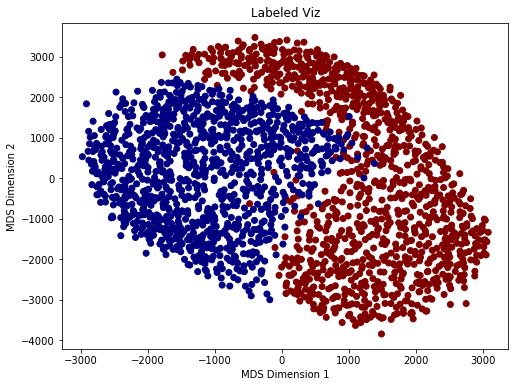

In [11]:
# Visualize with labels
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[(-len(cohesive_scores[0,:,0])):, 0], X_reduced[(-len(cohesive_scores[0,:,0])):, 1], c=np.concatenate([np.ones((1024,)), -np.ones((1024,))]), cmap=plt.cm.get_cmap("jet", 11))
plt.title("Labeled Viz")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.show()